# **Extending Analysis on IMF Loans and Immigration Rates: Random Forests**

## 1. Brief Introduction to Random Forests & How it Relates to our Project
The relationship between IMF Structural Adjustment Loans and immigration or asylum rates is complex. By leveraging ensemble learning models like Random Forests, we aim to capture both the linear and non-linear interactions among variables while assessing their relative importance.

Random Forests is based on decision trees. By constructing many decision trees which have high variance and low bias, and averaging their outputs, Random Forests reduces overfitting while maintaining strong predictive performance. The method calculates variable importance by measuring how much each feature reduces the model's RSS across the trees. This makes Random Forests a little more interpretable and identigies key drivers in datasets with complex relationships and high-dimensional features.

Additionally, Random Forests provide a measure of out-of-bag (OOB) error, which offers a built-in estimate of model accuracy without the need for a separate test set (Apparently, OOB estimates converge to LOOCV as the number of trees increases).

For an accessible primer on Random Forests (as well as regression and classification trees), see https://www.statlearning.com/



In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import statsmodels.api as sm

## 2. Basic Data Cleaning

In [6]:
# Load the dataset
data = pd.read_csv("final_data.csv")



data.head()

independent_vars = ["ArmedConflictGov", "SSA", "EAP", "SouthAmerica", 
                    "MiddleEast", "SouthAsia", "Control Corruption", "PoliticalStab", 
                    "Regulatory Quality", "GDPPCPPP", "NaturalDisasterRate","IMFDummy"]

data.rename(columns={"GDP per capita, PPP (constant 2017 international $) [NY.GDP.PCAP.PP.KD]":"GDPPCPPP"}, inplace="True")

# Replace '#DIV/0!' with NaN
data["ImmRate"] = data["ImmRate"].replace("#DIV/0!", np.nan)
data["ImmRate"] = data["ImmRate"].astype(float)

# get rid of commas
data["GDPPCPPP"] = data["GDPPCPPP"].str.replace(",", "")
data["GDPPCPPP"] = data["GDPPCPPP"].astype(float)


dependent_vars = {
    "AsyRate": "Asylum Seeker Rate",
    "RefRate": "Refugee Rate"
}

# Standardize the independent variables
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[independent_vars]), columns=independent_vars)
data_scaled[list(dependent_vars.keys())] = data[list(dependent_vars.keys())]

data_scaled.head()

,ArmedConflictGov,SSA,EAP,SouthAmerica,MiddleEast,SouthAsia,Control Corruption,PoliticalStab,Regulatory Quality,GDPPCPPP,NaturalDisasterRate,IMFDummy,AsyRate,RefRate
0,1.775408,-0.810093,-0.340279,-0.437048,-0.304604,3.760699,-1.156350,-1.708975,-1.944872,-1.000538,-0.124425,-0.630859,118.0491,11107.117150
1,1.775408,-0.810093,-0.340279,-0.437048,-0.304604,3.760699,-1.323610,-1.904246,-1.344809,-0.992193,-0.312795,-0.630859,111.0685,9020.103188
2,1.775408,-0.810093,-0.340279,-0.437048,-0.304604,3.760699,-1.312621,-2.022512,-1.466376,-0.998636,-0.312418,-0.630859,68.6950,9764.592778
3,1.775408,-0.810093,-0.340279,-0.437048,-0.304604,3.760699,-1.493330,-1.751704,-1.677123,-0.982949,-0.290986,-0.630859,54.6692,8443.578433
4,1.775408,-0.810093,-0.340279,-0.437048,-0.304604,3.760699,-1.479766,-1.932487,-1.726048,-0.977691,0.847778,-0.630859,56.5958,7973.011362


## 3. Fitting Random Forests Model

To fit the Random Forests model, we construct an ensemble of 100 decision trees. This approach reduces overfitting.

Key Steps:

- Out-of-Bag (OOB) Error: Random Forests provide a built-in cross-validation mechanism through OOB samples. By using data not included in the bootstrap samples for validation, we obtain an unbiased estimate of model performance without requiring a separate test set.
- Variable Importance: We calculate the importance of each feature based on its contribution to reducing the Residual Sum of Squares (RSS) across all trees. This metric helps identify the variables with the greatest predictive power.


Random Forest Regression for Asylum Seeker Rate (AsyRate):

OOB Error for AsyRate: 0.8295509897775492

Variable Importance:
               Variable  Importance
8    Regulatory Quality    0.230039
9              GDPPCPPP    0.208248
7         PoliticalStab    0.201955
6    Control Corruption    0.195690
10  NaturalDisasterRate    0.109443
3          SouthAmerica    0.031957
11             IMFDummy    0.008408
1                   SSA    0.004491
5             SouthAsia    0.003358
2                   EAP    0.003310
0      ArmedConflictGov    0.001622
4            MiddleEast    0.001480


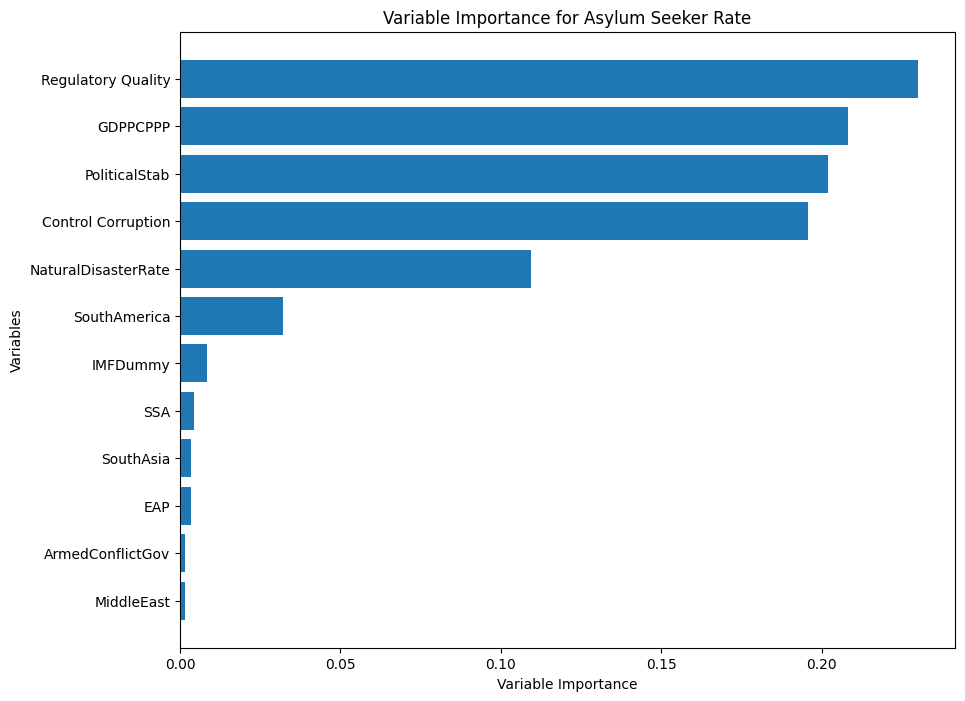


Random Forest Regression for Refugee Rate (RefRate):

OOB Error for RefRate: 0.3244029013391857

Variable Importance:
               Variable  Importance
9              GDPPCPPP    0.327681
7         PoliticalStab    0.233511
6    Control Corruption    0.164475
8    Regulatory Quality    0.161660
5             SouthAsia    0.060554
10  NaturalDisasterRate    0.034807
1                   SSA    0.008507
11             IMFDummy    0.004212
0      ArmedConflictGov    0.003659
3          SouthAmerica    0.000802
2                   EAP    0.000079
4            MiddleEast    0.000052


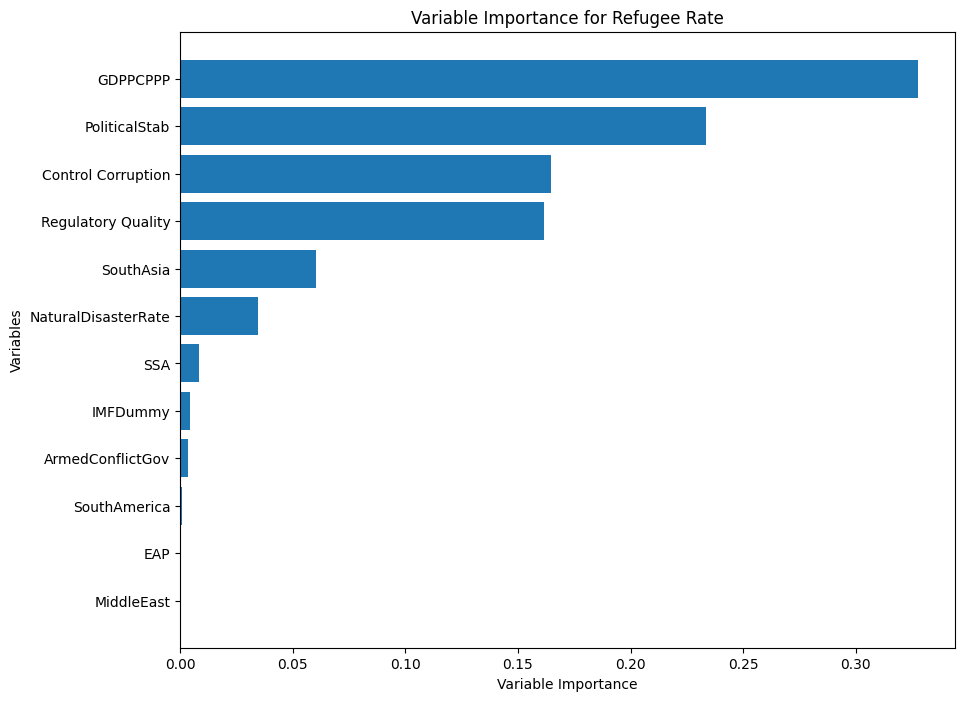

In [7]:
# Title: Perform LASSO Regression
# Step 3: Perform LASSO regression for each dependent variable

# Loop for Random Forests for each dependent variable
for dep_var, dep_description in dependent_vars.items():
    if dep_var not in data.columns:
        print(f"Column '{dep_var}' not found in the dataset. Skipping...")
        continue

    print(f"\nRandom Forest Regression for {dep_description} ({dep_var}):\n")

    # Define the independent and dependent variables
    X = data[independent_vars]
    y = data[dep_var]

    # Combine X and y into a single DataFrame for dropping NaN values
    combined_data = pd.concat([X, y], axis=1).dropna()

    # Separate back into X and y after dropping NaN
    X = combined_data[independent_vars]
    y = combined_data[dep_var]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
    rf_model.fit(X_train, y_train)

    # Calculate OOB error
    oob_error = 1 - rf_model.oob_score_
    print(f"OOB Error for {dep_var}: {oob_error}")

    # Calculate variable importance
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "Variable": independent_vars,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print("\nVariable Importance:")
    print(feature_importance_df)

    # Plot the variable importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["Variable"], feature_importance_df["Importance"])
    plt.xlabel("Variable Importance")
    plt.ylabel("Variables")
    plt.title(f"Variable Importance for {dep_description}")
    plt.gca().invert_yaxis()
    plt.show()


## 4. Conclusion:
Congruent with results obtained using hierarchical models and LASSO regression, IMF Structural Adjustment Loans do not seem significant in predicting changes in immigration rates (average score of IMF Loans ~.7%). Though hierarchical models and LASSO/RandomForests serve differenet purposes, the former focusing on causality and the latter prediction, there does not seem to be any casual or predictive significance of IMF Loans as it relates to asylum seekers and refugees from a given country.